In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
import glob
from torch.nn.utils.rnn import pad_sequence

# path to pose_feature (2D) 
path1 = os.path.expanduser('~/MPS-Net_release/output/pose_feature/*.npy')
pose_feature_files = glob.glob(path1)

# file names
file_names = [os.path.splitext(os.path.basename(file))[0] for file in pose_feature_files]

# A list of numpy arrays 
pose_features = [np.load(file) for file in pose_feature_files]

# Convert from numpy arrays to tensors
pose_features_tensors = [torch.from_numpy(arr) for arr in pose_features]

# Pad since each numpy array has different sizes
pose_features_padded = pad_sequence(pose_features_tensors, batch_first=True) 

# print(len(file_names))      # 383
# print(pose_features[0].shape)   # (num_frames, 72)

# print(pose_features_padded[0].shape)    # torch.Size([827, 72])

In [3]:
# Flatten and convert to DataFrame 

# First, convert Pytorch tensor to numpy array
pose_features_np = pose_features_padded.numpy()

# Flatten each feature into a single row 
num_samples = pose_features_np.shape[0]
pose_features_np = pose_features_np.reshape((num_samples, -1))

# print(pose_features_np.shape)       # (383, 59544)

# Convert to DataFrame
pose_features_df = pd.DataFrame(pose_features_np)

# Insert names of videos 
pose_features_df.insert(0, 'subjectid', file_names)

pose_features_df

,subjectid,0,1,2,3,4,5,6,7,8,...,59534,59535,59536,59537,59538,59539,59540,59541,59542,59543
0,mYXJQupd,2.673438,-0.310733,0.558719,-0.678851,0.129317,0.366609,-0.471315,-0.047316,-0.275155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ytlu6T69,2.268841,-0.827731,1.765634,-0.911455,-0.038574,0.094112,-0.844047,0.044065,0.001506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ucT4dryZ,2.323613,-0.698461,1.585673,-0.668434,-0.020585,0.262638,-0.628620,0.044056,-0.024906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Di0gPE0H,2.936863,-0.438569,0.933661,-0.970730,0.049928,0.279009,-0.550194,-0.023954,-0.088879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,bePyG1Du,2.694114,0.466591,-0.961922,-0.796835,-0.011175,0.131201,-0.911300,-0.054597,-0.172618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,yKdKYz23,2.526262,0.488407,-0.837174,-0.551301,-0.094422,0.005145,-0.642834,-0.050453,-0.232887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,a6j4D1CL,2.612134,-0.548280,1.077394,-0.641671,0.026008,0.198205,-0.531655,0.007241,-0.076018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,NCmOpQMW,2.804719,-0.430133,1.219248,-0.599391,0.001429,0.055585,-0.678752,0.080012,-0.113193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,ZR3QAZmu,2.577077,-0.207856,0.540177,-0.616740,0.014324,0.223345,-0.666742,0.030372,-0.054015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Load survey data
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


In [5]:
# joint dataframes by subjectid
df_join = pose_features_df.set_index('subjectid').join(df_survey.set_index('subjectid'), how='inner')
df_join

,0,1,2,3,4,5,6,7,8,9,...,59535,59536,59537,59538,59539,59540,59541,59542,59543,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
mYXJQupd,2.673438,-0.310733,0.558719,-0.678851,0.129317,0.366609,-0.471315,-0.047316,-0.275155,0.557255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Ytlu6T69,2.268841,-0.827731,1.765634,-0.911455,-0.038574,0.094112,-0.844047,0.044065,0.001506,0.791298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ucT4dryZ,2.323613,-0.698461,1.585673,-0.668434,-0.020585,0.262638,-0.628620,0.044056,-0.024906,0.541472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Di0gPE0H,2.936863,-0.438569,0.933661,-0.970730,0.049928,0.279009,-0.550194,-0.023954,-0.088879,0.623421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
bePyG1Du,2.694114,0.466591,-0.961922,-0.796835,-0.011175,0.131201,-0.911300,-0.054597,-0.172618,0.916406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yKdKYz23,2.526262,0.488407,-0.837174,-0.551301,-0.094422,0.005145,-0.642834,-0.050453,-0.232887,0.810844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
a6j4D1CL,2.612134,-0.548280,1.077394,-0.641671,0.026008,0.198205,-0.531655,0.007241,-0.076018,0.535807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
NCmOpQMW,2.804719,-0.430133,1.219248,-0.599391,0.001429,0.055585,-0.678752,0.080012,-0.113193,0.582623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [7]:
NUM_TRAIN = len(train_indices)      # 305
NUM_VAL = len(val_indices)          # 39
NUM_TEST = len(test_indices)        # 39

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [8]:
# Check for number of OA positive and number of samples in the dataset
print(df_join['OA_check'].count())  
print(df_join['OA_check'].sum())    
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data['OA_check'].count())  
print(train_data['OA_check'].sum())    

# Validation set - This implies that if the model always predicts 0, it would have 94% val accuracy
print(val_data['OA_check'].count()) 
print(val_data['OA_check'].sum())   

# Test set - This implies that if the model always predicts 0, it would have 94% test accuracy
print(test_data['OA_check'].count()) 
print(test_data['OA_check'].sum()) 

383
24
305
20
39
2
39
2


In [9]:
# Skip Normalization

In [10]:
# Create DataLoaders

# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

In [11]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 59544]) torch.Size([64])
tensor([[ 2.7561, -0.4934,  1.1595,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.3889, -0.5206,  1.0628,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.5782,  0.5240, -1.3078,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.5540, -0.4943,  0.9199,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.3787,  0.6269, -1.0925,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.6917, -0.2643,  0.4805,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64) tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


**# Create dataloaders with upsampling**

In [12]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
# _, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

In [13]:
train = CustomDataset(dataframe=train_data, transform=None)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

# _, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

**# Barebones Model**

Train model with unnormalized inputs, no oversampling

In [14]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 59544
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.1580, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = 0.2291, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 0.2485, train_acc = 93.7705, val_acc = 94.8718, train_pos = 0.3279, val_pos = 0.0000
Epoch 3, loss = 0.0968, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = 0.0594, train_acc = 93.4426, val_acc = 94.8718, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = 0.1352, train_acc = 94.0984, val_acc = 94.8718, train_pos = 0.6557, val_pos = 0.0000
Epoch 6, loss = 0.1401, train_acc = 95.0820, val_acc = 94.8718, train_pos = 1.6393, val_pos = 0.0000
Epoch 7, loss = 0.1549, train_acc = 94.4262, val_acc = 94.8718, train_pos = 0.9836, val_pos = 0.0000
Epoch 8, loss = 0.0966, train_acc = 94.4262, val_acc = 94.8718, train_pos = 0.9836, val_pos = 0.0000
Epoch 9, loss = 0.0779, train_acc = 95.0820, val_acc = 94.8718, train_pos = 1.6393, val_pos

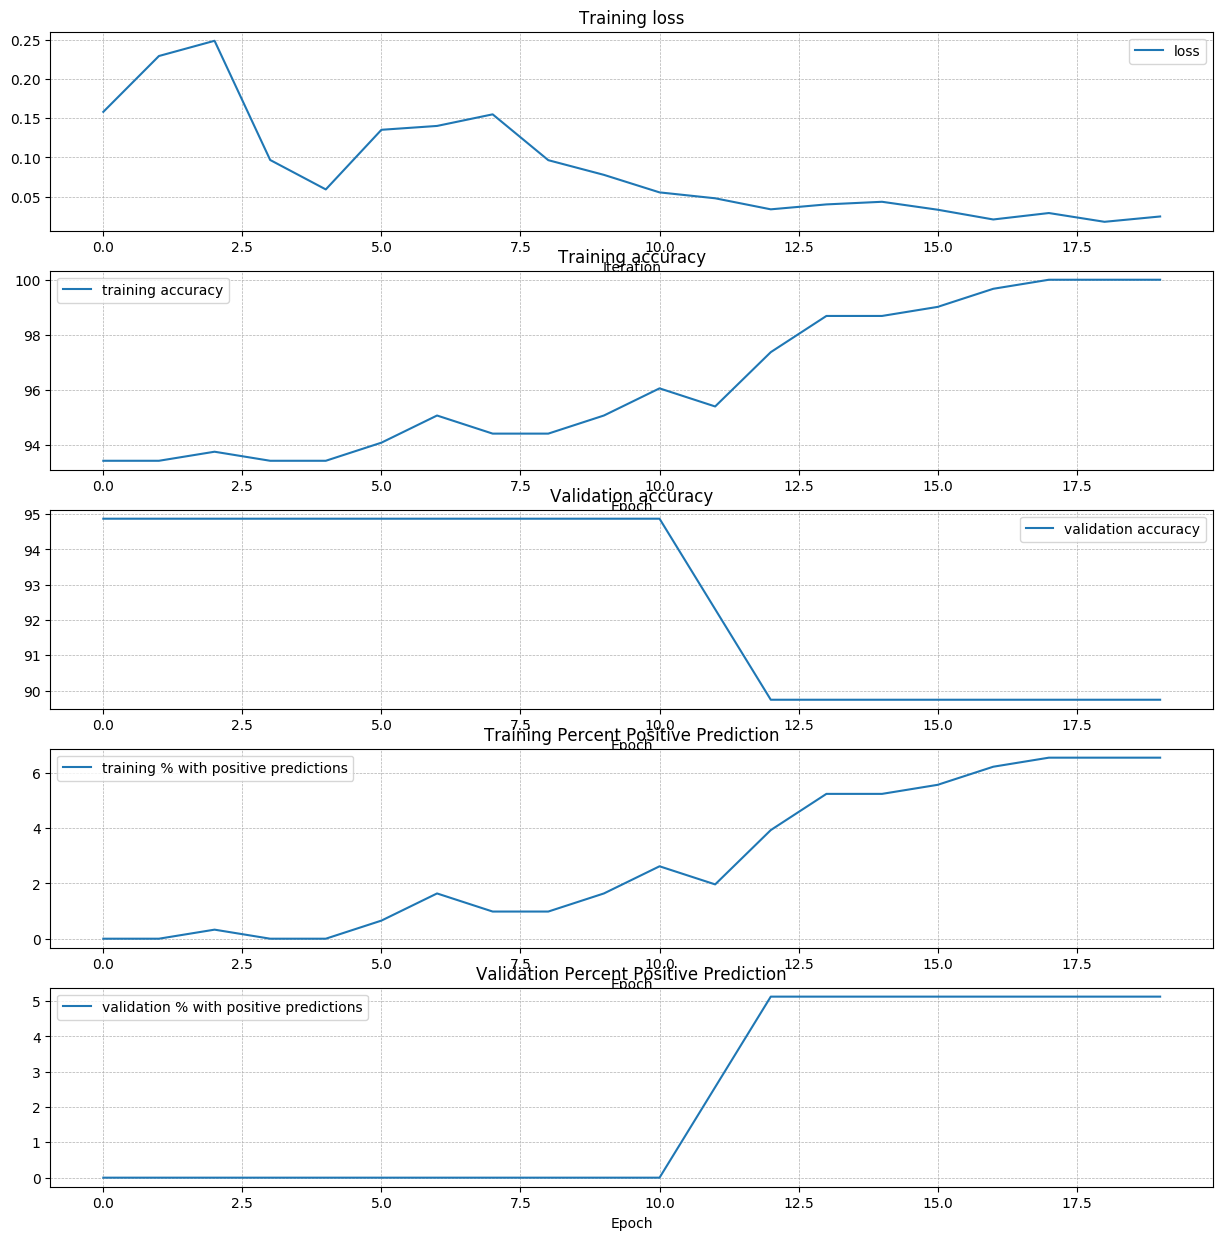

In [15]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

Train model with unnormalized inputs, with oversampling


In [16]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 59544
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.4107, train_acc = 66.2295, val_acc = 30.7692, train_pos = 31.4754, val_pos = 74.3590
Epoch 1, loss = 0.2822, train_acc = 75.4098, val_acc = 87.1795, train_pos = 51.8033, val_pos = 7.6923
Epoch 2, loss = 0.3235, train_acc = 79.0164, val_acc = 79.4872, train_pos = 39.3443, val_pos = 25.6410
Epoch 3, loss = 0.1710, train_acc = 91.1475, val_acc = 87.1795, train_pos = 52.4590, val_pos = 7.6923
Epoch 4, loss = 0.1059, train_acc = 91.1475, val_acc = 84.6154, train_pos = 43.9344, val_pos = 10.2564
Epoch 5, loss = 0.1207, train_acc = 97.7049, val_acc = 84.6154, train_pos = 56.3934, val_pos = 10.2564
Epoch 6, loss = 0.0855, train_acc = 98.3607, val_acc = 89.7436, train_pos = 52.1311, val_pos = 5.1282
Epoch 7, loss = 0.0531, train_acc = 99.0164, val_acc = 89.7436, train_pos = 50.1639, val_pos = 5.1282
Epoch 8, loss = 0.0606, train_acc = 99.0164, val_acc = 89.7436, train_pos = 51.4754, val_pos = 5.1282
Epoch 9, loss = 0.0254, train_acc = 99.3443, val_acc = 89.7436, train_pos = 52

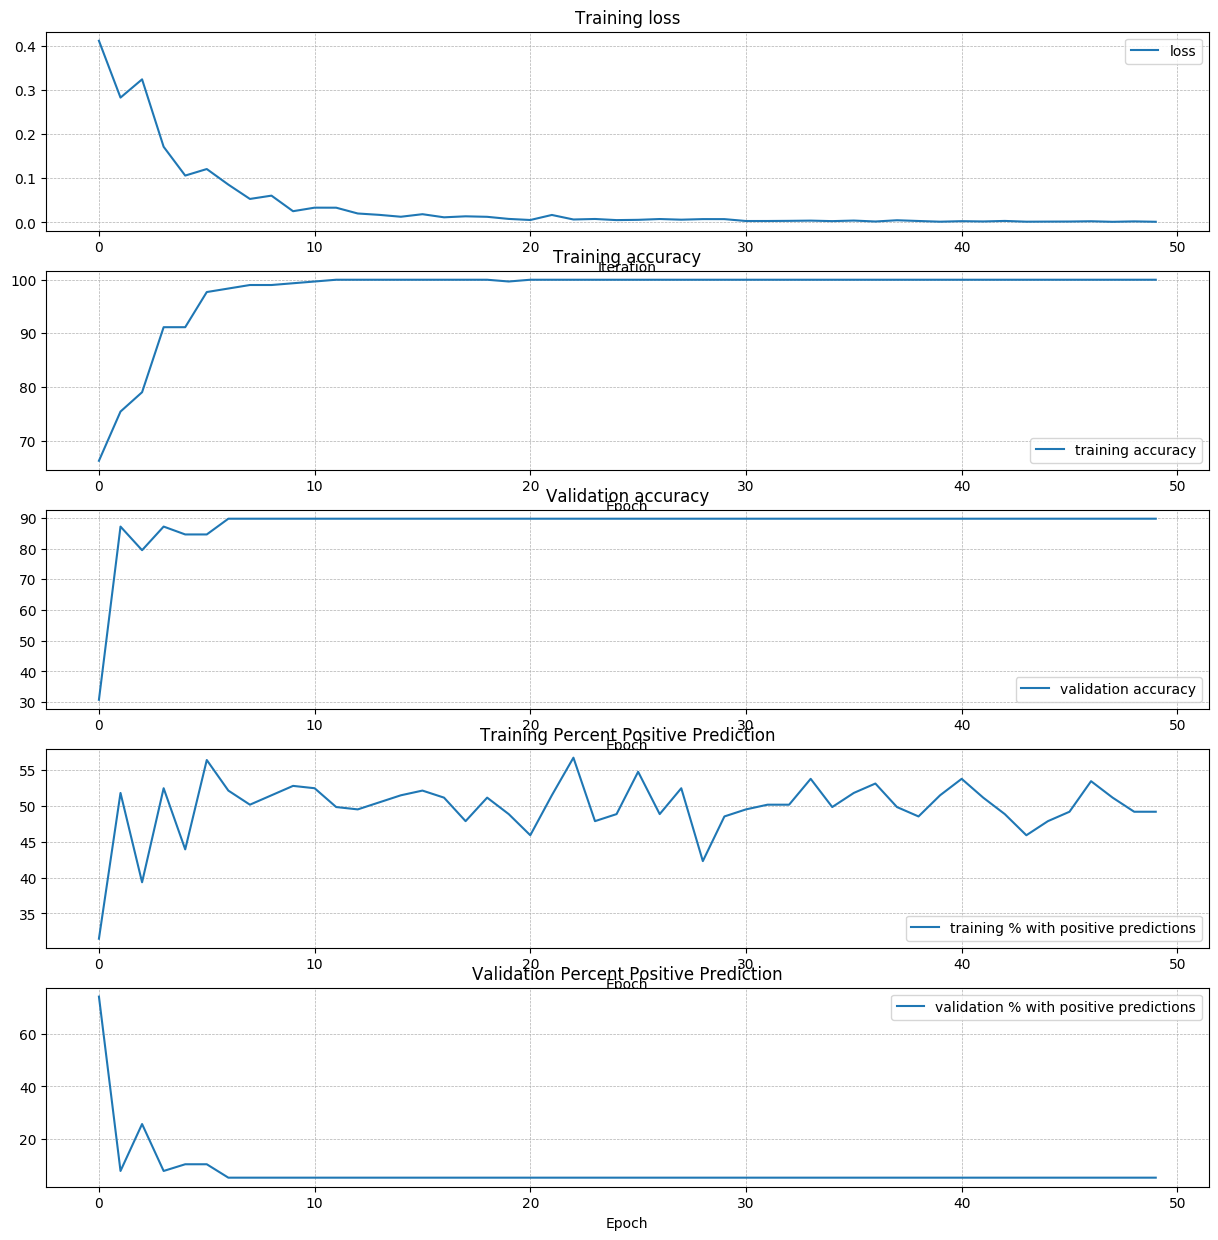

In [17]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

Train model with unnormalized inputs, no oversampling, with weighted loss


In [18]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 59544
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 3.1165, train_acc = 41.6393, val_acc = 41.0256, train_pos = 57.7049, val_pos = 64.1026
Epoch 1, loss = 2.0092, train_acc = 73.4426, val_acc = 92.3077, train_pos = 26.5574, val_pos = 2.5641
Epoch 2, loss = 0.7938, train_acc = 94.4262, val_acc = 87.1795, train_pos = 1.6393, val_pos = 12.8205
Epoch 3, loss = 0.8802, train_acc = 81.9672, val_acc = 82.0513, train_pos = 20.0000, val_pos = 23.0769
Epoch 4, loss = 0.9263, train_acc = 80.9836, val_acc = 87.1795, train_pos = 20.9836, val_pos = 7.6923
Epoch 5, loss = 0.9549, train_acc = 95.7377, val_acc = 92.3077, train_pos = 4.2623, val_pos = 2.5641
Epoch 6, loss = 0.6146, train_acc = 96.0656, val_acc = 89.7436, train_pos = 5.2459, val_pos = 5.1282
Epoch 7, loss = 0.5204, train_acc = 94.7541, val_acc = 87.1795, train_pos = 10.4918, val_pos = 7.6923
Epoch 8, loss = 0.4271, train_acc = 95.4098, val_acc = 89.7436, train_pos = 9.1803, val_pos = 5.1282
Epoch 9, loss = 0.4953, train_acc = 98.3607, val_acc = 89.7436, train_pos = 6.8852,

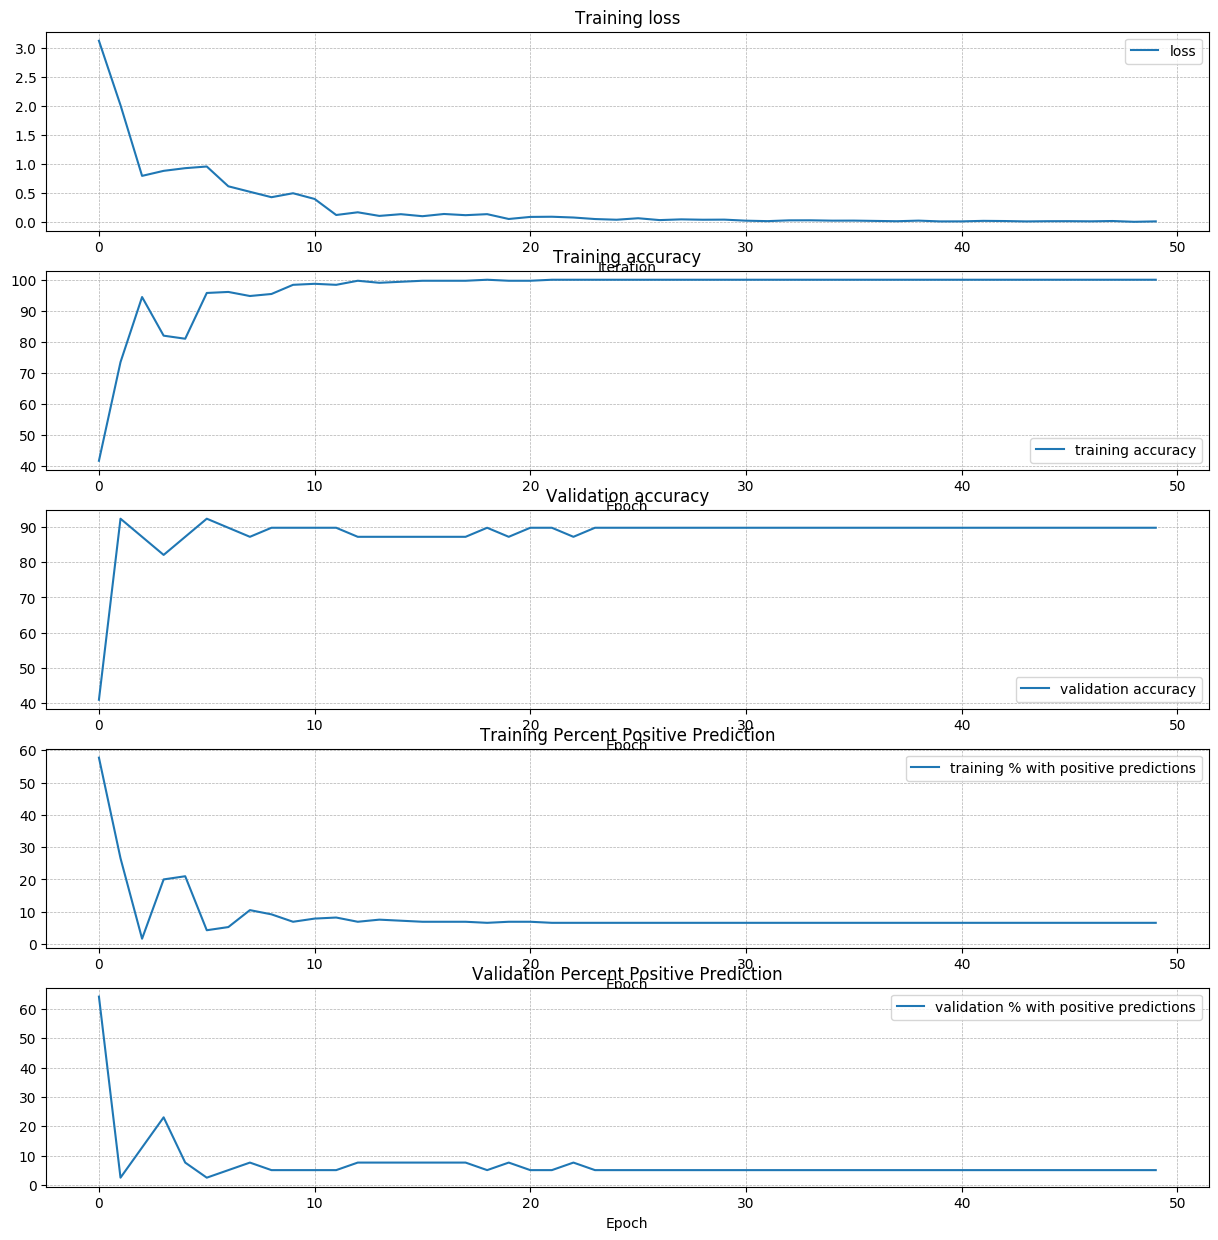

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()